# Indeed.com Job Analysis


      
###Tutorial  
* Web Scraping Indeed for Key Data Science Job Skills [link](https://jessesw.com/Data-Science-Skills/)
* Percent-Encoding Reserved Characters [link](https://en.wikipedia.org/wiki/Percent-encoding) 

###Libraries
* This tutorial requires a few python libraries
  * BeautifulSoup4
  * NLTK [[guide]](http://www.nltk.org/install.html)
  * Download NLTK data [[guide]](http://www.nltk.org/data.html)
  * urllib2 or urllib3   
  
> ```pip install beautifulsoup4
pip install -U nltk```

In [1]:
!pip install beautifulsoup4

In [2]:
!pip install -U nltk

Requirement already up-to-date: nltk in /Users/alston/opt/anaconda3/lib/python3.7/site-packages (3.5)


In [1]:
# import libraries
from bs4 import BeautifulSoup # For HTML parsing
import urllib # Website connections
import re # Regular expressions
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
from nltk.corpus import stopwords # Filter out stopwords, such as 'the', 'or', 'and'
import pandas as pd # For converting results to a dataframe and bar chart plots
%matplotlib inline

In [ ]:
https://ca.indeed.com/rc/clk?jk=edba7cea10edf2ac&fccid=537b899e30af3338&vjs=3

## Example - Text Cleaning function

In [14]:
# function to cleanup text
def text_cleaner(website):
    '''
    This function just cleans up the raw html so that I can look at it.
    Inputs: a URL to investigate
    Outputs: Cleaned text only
    '''
    try:
        site = urllib.request.urlopen(website).read() # Connect to the job posting
        # print(site)
    except: 
        return   # Need this in case the website isn't there anymore or some other weird connection problem 

    soup_obj = BeautifulSoup(site) # Get the html from the site

    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object

    text = soup_obj.get_text() # Get the text from this
    lines = (line.strip() for line in text.splitlines()) # break into lines
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each

    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  

    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line

    # Now clean out all of the unicode junk (this line works great!!!)
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception

#     text = re.sub("[^a-zA-Z.+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
#                                                 # Also include + for C++

    text = text.lower().split()  # Go to lower case and split them apart
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    text = [w.decode("utf-8") for w in text if not w.decode("utf-8") in stop_words]
    text = list(set(text)) # Last, just get the set of these. Ignore counts (we are just looking at whether a term existed
                            # or not on the website)
    return text

# note the function itself doesn't return anything if you run this cell

In [15]:
sample = text_cleaner('http://ca.indeed.com/rc/clk?jk=46af51d14dbd6b77&tk=1eo6cd5gju2hu800&vjs=3')

In [16]:
sample[:20]

['recommendation)',
 'asset.',
 'collaboratively',
 'accepting',
 'science,',
 'focus',
 '&',
 'delivery',
 'crm,',
 'loyaltyone.',
 'jobscompany',
 'efficiencies',
 'portfolio,',
 'physics.',
 'toronto,',
 'reports',
 'marketing',
 'provide',
 'planning,',
 'segmentation,']

In [5]:
# Test the text_cleaner function
# sample = text_cleaner('https://ca.indeed.com/viewjob?jk=68f2d9c27a08bdf0&tk=1cndd9bpf0mql5nn&from=serp&alid=3&advn=4239586925542806')
sample = text_cleaner('http://ca.indeed.com/rc/clk?jk=7a8d70b47eba10a6&fccid=f2087b51205d4920&vjs=3')
sample[:20] # Just show the first 20 words


['service',
 'unit',
 'standards',
 'open:',
 'development,',
 'requirements',
 'highly',
 'assigned.',
 'government.',
 'consultantcity',
 'accessibility',
 'reports,',
 'jobs',
 'rates',
 'team,',
 'collaboration',
 'priorities.',
 'act',
 'provides',
 'responsibilities:']

## Example - Using BeatifulSoup to parse job links

In [5]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib.request # Website connections
import re

city='Toronto'
state='ON'
final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)

# Make sure the city specified works properly if it has more than one word (such as San Francisco)
# "San Francisco" is one word so the space between needs special care
# In a URL there cannot be any space. We use percent-encoding %2C as space
if city is not None:
    final_city = city.split() 
    final_city = '+'.join(word for word in final_city)
    final_site_list = ['http://ca.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
else:
    final_site_list = ['http://ca.indeed.com/jobs?q="', final_job, '"']

base_url = 'http://ca.indeed.com'
    
final_site = ''.join(final_site_list)

print ("----- Print the URL component as list -----")
print (final_site_list)
print
print ("----- Print the final concatenated URL -----")
print (final_site)

final_site = final_site.replace(' ', '%20')  # replace space with %20

# read the URL content
html = urllib.request.urlopen(final_site).read() # Open up the front page of our search first

# create a beautifulsoup object
soup = BeautifulSoup(html, "lxml") # Get the html from the first page

# extract url links
job_link_area = soup.find(id = 'resultsCol') # The center column on the page where the job postings exist



----- Print the URL component as list -----
['http://ca.indeed.com/jobs?q=%22', 'data+scientist', '%22&l=', 'Toronto', '%2C+', 'ON']
----- Print the final concatenated URL -----
http://ca.indeed.com/jobs?q=%22data+scientist%22&l=Toronto%2C+ON


In [6]:
job_link_area.find_all(name="a", attrs={'class': re.compile(r'^tapItem fs-unmask result'), "target":"_blank"})

[<a class="tapItem fs-unmask result job_dea389cfe31407bd resultWithShelf sponTapItem desktop" data-hide-spinner="true" data-hiring-event="false" data-jk="dea389cfe31407bd" data-mobtk="1fj79leo0him6800" href="/rc/clk?jk=dea389cfe31407bd&amp;fccid=d7114f1cac8d0711&amp;vjs=3" id="job_dea389cfe31407bd" rel="nofollow" target="_blank"><div class="slider_container"><div class="slider_list"><div class="slider_item"><div class="job_seen_beacon"><table cellpadding="0" cellspacing="0" class="jobCard_mainContent" role="presentation"><tbody><tr><td class="resultContent"><div class="heading4 color-text-primary singleLineTitle tapItem-gutter"><h2 class="jobTitle jobTitle-color-purple jobTitle-newJob"><div class="new topLeft holisticNewBlue desktop"><span class="label">new</span></div><span title="Data Scientist I">Data Scientist I</span></h2></div><div class="heading6 company_location tapItem-gutter"><pre><span class="companyName"><a class="turnstileLink companyOverviewLink" data-tn-element="companyN

In [8]:
job_URLS = [base_url + link.get('href') for link in job_link_area.find_all(name="a", attrs={'class': re.compile(r'^tapItem fs-unmask result'), "target":"_blank"})] # Get the URLS for the jobs



In [9]:

print ("----- Print the list of job URLs -----")
for j in job_URLS:
    print(j)

----- Print the list of job URLs -----
http://ca.indeed.com/rc/clk?jk=dea389cfe31407bd&fccid=d7114f1cac8d0711&vjs=3
http://ca.indeed.com/rc/clk?jk=f7fc1a9832ce87e7&fccid=cba01270e96bb012&vjs=3
http://ca.indeed.com/rc/clk?jk=6fb1127e8a9898ff&fccid=0b74c73a7d280485&vjs=3
http://ca.indeed.com/rc/clk?jk=708036fdcf3dcd1b&fccid=43a69183767d4301&vjs=3
http://ca.indeed.com/rc/clk?jk=27760c298988949e&fccid=de71a49b535e21cb&vjs=3
http://ca.indeed.com/rc/clk?jk=da35e6b671bcb0aa&fccid=39819b98bf274ae4&vjs=3
http://ca.indeed.com/company/Three-Point-Turn/jobs/Data-Engineer-59f9c987b33193d2?fccid=622ee046c19fd562&vjs=3
http://ca.indeed.com/rc/clk?jk=378471e396d9c5ba&fccid=904e26b72f6a1767&vjs=3
http://ca.indeed.com/rc/clk?jk=b6de71aa40143b9c&fccid=cc0861c00ab24001&vjs=3
http://ca.indeed.com/company/Altair-Engineering/jobs/Data-Scientist-df543b8908e52426?fccid=1a392d96e9e92e3f&vjs=3
http://ca.indeed.com/rc/clk?jk=ad9473db9ff0d27a&fccid=6ecdfff5c52c8dc6&vjs=3
http://ca.indeed.com/rc/clk?jk=4c878f1235bd

In [10]:
from bs4 import BeautifulSoup # For HTML parsing
import urllib.request # Website connections

city='Toronto'
state='ON'
final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)

# Make sure the city specified works properly if it has more than one word (such as San Francisco)
# "San Francisco" is one word so the space between needs special care
# In a URL there cannot be any space. We use percent-encoding %2C as space
if city is not None:
    final_city = city.split() 
    final_city = '+'.join(word for word in final_city)
    final_site_list = ['http://ca.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
else:
    final_site_list = ['http://ca.indeed.com/jobs?q="', final_job, '"']

base_url = 'http://ca.indeed.com'
    
final_site = ''.join(final_site_list)

print ("----- Print the URL component as list -----")
print (final_site_list)
print
print ("----- Print the final concatenated URL -----")
print (final_site)

final_site = final_site.replace(' ', '%20')  # replace space with %20

# read the URL content
html = urllib.request.urlopen(final_site).read() # Open up the front page of our search first

# create a beautifulsoup object
soup = BeautifulSoup(html, "lxml") # Get the html from the first page

# extract url links
job_link_area = soup.find(id = 'resultsCol') # The center column on the page where the job postings exist

# job_URLS = []
# for link in job_link_area.find_all(name="a", attrs={"class":"jobtitle turnstileLink","data-tn-element":"jobTitle"}):
#     print(link.get('href'))
#     print ()

# job_URLS = [base_url + link.get('href') for link in job_link_area.find_all(name="a", attrs={"class":"jobtitle turnstileLink","data-tn-element":"jobTitle"})] # Get the URLS for the jobs
# job_URLS = filter(lambda x:'clk' in x, job_URLS)
job_URLS = [base_url + link.get('href') for link in job_link_area.find_all(name="a", attrs={'class': re.compile(r'^tapItem fs-unmask result'), "target":"_blank"})] # Get the URLS for the jobs



print ("----- Print the list of job URLs -----")
for j in job_URLS:
    print(j)

----- Print the URL component as list -----
['http://ca.indeed.com/jobs?q=%22', 'data+scientist', '%22&l=', 'Toronto', '%2C+', 'ON']
----- Print the final concatenated URL -----
http://ca.indeed.com/jobs?q=%22data+scientist%22&l=Toronto%2C+ON
----- Print the list of job URLs -----
http://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Cd8rgsyGhFvMrD1rf7FXHjGc1BkNqwZLJ5WjcsKW1J4WnsFct9ejhblJAjZEsJEyprzD5F1x4WPG9lTIAkJOgu3hPep7phK3R2MaqjBkWMPqsZEY5gAP-csuTFk2IIWUeaGVUG5eHaWP2ct_gOohRLH7XdxpQfOR4lUegY5v3VLiQjzEn7jjNedzf840ZnMVeUd3N3oI1COslOz54Q_eAQQfsQftYVUmHMwnlZUHC1zm86sTkuDQ0gqc6D5P-Ka8vMXXA2oJ1TWeS2r99KEgAe6bWmJcWtsidI8Pi47lI1lStDOUy5G5fIt9o1ptVw1LigT4a-RlsnNqqnyRYxGxsQwNeMkDHRKG91C8w9rvwI3YzotWjIunNz5fu9NBT2aBk2UXe6i4wvw9NciQN2XEX5RoeobxFYqO888K4SVCJHroB1KVNNcBSM3Wirjs_7iDdAR16nr7mavPMOIAMCUDKGZOVOjmkmEMdFnCDjoQleHwl8RD0mwyT37yanpnVRCZOxxld19OkMcUmkNspH9runD_wHaAuHECkGxZI3-ENGdfmRF12fFPiDWGkD_7CVu5sgMvVyfJIIJsZBUjDxLC7QEB-XMMlk1a48lR8CTl5NJuymIO9DC-AB0W16HQ_o0a-V_uurzgGc7DKTvBDx558C7oOC2O

In [ ]:
# job_URLS = filter(lambda x:'clk' in x, job_URLS)

## Indeed Job Scraping Program 

In [12]:
def skills_info(city = None, state = None, job_title = None):
    '''
    This function will take a desired city/state and look for all new job postings
    on Indeed.com. It will crawl all of the job postings and keep track of how many
    use a preset list of typical data science skills. The final percentage for each skill
    is then displayed at the end of the collation. 
        
    Inputs: The location's city and state. These are optional. If no city/state is input, 
    the function will assume a national search (this can take a while!!!).
    Input the city/state as strings, such as skills_info('Chicago', 'IL').
    Use a two letter abbreviation for the state.
    
    Output: A bar chart showing the most commonly desired skills in the job market for 
    a data scientist. 
    '''
        
    # final_job = 'data+scientist' # searching for data scientist exact fit("data scientist" on Indeed search)
    final_job = str(job_title)
    
    # Make sure the city specified works properly if it has more than one word (such as San Francisco)
    if city is not None:
        final_city = city.split() 
        final_city = '+'.join(word for word in final_city)
        final_site_list = ['http://ca.indeed.com/jobs?q=%22', final_job, '%22&l=', final_city,
                    '%2C+', state] # Join all of our strings together so that indeed will search correctly
    else:
        final_site_list = ['http://ca.indeed.com/jobs?q="', final_job, '"']

    final_site = ''.join(final_site_list) # Merge the html address together into one string

    
    base_url = 'http://ca.indeed.com'
    
    
    try:
        html = urllib.request.urlopen(final_site).read() # Open up the front page of our search first
    except:
        'That city/state combination did not have any jobs. Exiting . . .' # In case the city is invalid
        return
    soup = BeautifulSoup(html) # Get the html from the first page
    
    # Now find out how many jobs there were
#     print(soup)
    
    num_jobs_area = soup.find(id = 'searchCountPages').string.encode('utf-8') # Now extract the total number of jobs found
                                                                        # The 'searchCount' object has this

    job_numbers = re.search('Page 1 of (\d+)', num_jobs_area.decode('ISO-8859-1')).group(1)
    
#     job_numbers = re.findall('\d+', num_jobs_area) # Extract the total jobs found from the search result
    
    
    if len(job_numbers) > 3: # Have a total number of jobs greater than 1000
        total_num_jobs = (int(job_numbers[2])*1000) + int(job_numbers[3])
    else:
        total_num_jobs = int(job_numbers) 
    
    city_title = city
    if city is None:
        city_title = 'Nationwide'
        
    print ('There were', total_num_jobs, 'jobs found,', city_title) # Display how many jobs were found
    
    num_pages = int(total_num_jobs/10) # This will be how we know the number of times we need to iterate over each new
                                      # search result page
    print(num_pages)
    job_descriptions = [] # Store all our descriptions in this list
    
    for i in range(1,num_pages+1): # Loop through all of our search result pages
        print ('Getting page', i)
        start_num = str(i*10) # Assign the multiplier of 10 to view the pages we want
        current_page = ''.join([final_site, '&start=', start_num])
        # Now that we can view the correct 10 job returns, start collecting the text samples from each
            
        html_page = urllib.request.urlopen(current_page).read() # Get the page
            
        page_obj = BeautifulSoup(html_page, "lxml") # Locate all of the job links
        job_link_area = page_obj.find(id = 'resultsCol') # The center column on the page where the job postings exist
            
        job_URLS = [base_url + link.get('href') for link in job_link_area.find_all(name="a", attrs={'class': re.compile(r'^tapItem fs-unmask result'), "target":"_blank"})] # Get the URLS for the jobs
    
        job_URLS = list(filter(lambda x:'clk' in x, job_URLS)) # Now get just the job related URLS
            
#         print(job_URLS)
        for j in range(0,len(job_URLS)):
            final_description = text_cleaner(job_URLS[j])
            if final_description: # So that we only append when the website was accessed correctly
                for i in final_description:
                    job_descriptions.append(i)
            sleep(10) # So that we don't be jerks. If you have a very fast internet connection you could hit the server a lot! 
        
    print ('Done with collecting the job postings!')    
    print ('There were', len(job_descriptions), 'words successfully found.')
    
    
    doc_frequency = Counter(job_descriptions) # This will create a full counter of our terms. 
#     [doc_frequency.update(item) for item in job_descriptions] # List comp
    
    # Now we can just look at our final dict list inside doc_frequency
    
    # Obtain our key terms and store them in a dict. These are the key data science skills we are looking for
    
    prog_lang_dict = Counter({'R':doc_frequency['r'], 'Python':doc_frequency['python'],
                    'Java':doc_frequency['java'], 'C++':doc_frequency['c++'],
                    'Ruby':doc_frequency['ruby'],
                    'Perl':doc_frequency['perl'], 'Matlab':doc_frequency['matlab'],
                    'JavaScript':doc_frequency['javascript'], 'Scala': doc_frequency['scala']})
                      
    analysis_tool_dict = Counter({'Excel':doc_frequency['excel'],  'Tableau':doc_frequency['tableau'],
                        'D3.js':doc_frequency['d3.js'], 'SAS':doc_frequency['sas'],
                        'SPSS':doc_frequency['spss'], 'D3':doc_frequency['d3']})  

    hadoop_dict = Counter({'Hadoop':doc_frequency['hadoop'], 'MapReduce':doc_frequency['mapreduce'],
                'Spark':doc_frequency['spark'], 'Pig':doc_frequency['pig'],
                'Hive':doc_frequency['hive'], 'Shark':doc_frequency['shark'],
                'Oozie':doc_frequency['oozie'], 'ZooKeeper':doc_frequency['zookeeper'],
                'Flume':doc_frequency['flume'], 'Mahout':doc_frequency['mahout']})
                
    database_dict = Counter({'SQL':doc_frequency['sql'], 'NoSQL':doc_frequency['nosql'],
                    'HBase':doc_frequency['hbase'], 'Cassandra':doc_frequency['cassandra'],
                    'MongoDB':doc_frequency['mongodb']})
                     
               
    overall_total_skills = prog_lang_dict + analysis_tool_dict + hadoop_dict + database_dict # Combine our Counter objects
    
        
    
    final_frame = pd.DataFrame(overall_total_skills.items(), columns = ['Term', 'NumPostings']) # Convert these terms to a 
                                                                                                # dataframe 
    # Change the values to reflect a percentage of the postings 
    
    final_frame.NumPostings = (final_frame.NumPostings)*100/len(job_descriptions) # Gives percentage of job postings 
                                                                                    #  having that term 
    
    # Sort the data for plotting purposes
    
    final_frame.sort_values(by = ['NumPostings'], ascending = False, inplace = True)
    
    # Get it ready for a bar plot
        
    final_plot = final_frame.plot(x = 'Term', kind = 'bar', legend = None, 
                            title = 'Percentage of Data Scientist Job Ads with a Key Skill, ' + city_title)
        
    final_plot.set_ylabel('Percentage Appearing in Job Ads')
    fig = final_plot.get_figure() # Have to convert the pandas plot object to a matplotlib object
        
        
    return fig, final_frame # End of the function

There were 236 jobs found, Mississauga
23
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5


/Users/alston/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: invalid escape sequence '\ '


Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15


/Users/alston/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: invalid escape sequence '\s'


Getting page 16
Getting page 17
Getting page 18
Getting page 19
Getting page 20
Getting page 21
Getting page 22
Getting page 23
Done with collecting the job postings!
There were 111568 words successfully found.


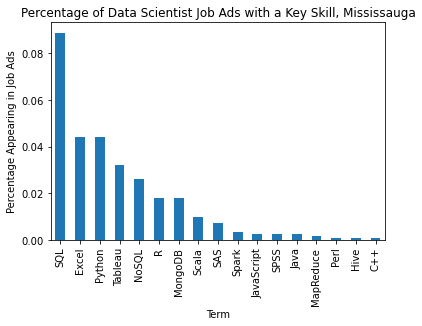

In [17]:
seattle_info = skills_info(city = 'Mississauga', state = 'ON', job_title = 'Data+Analyst') 

There were 174 jobs found, Mississauga
17
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Getting page 11
Getting page 12
Getting page 13
Getting page 14
Getting page 15
Getting page 16
Getting page 17
Done with collecting the job postings!
There were 65982 words successfully found.


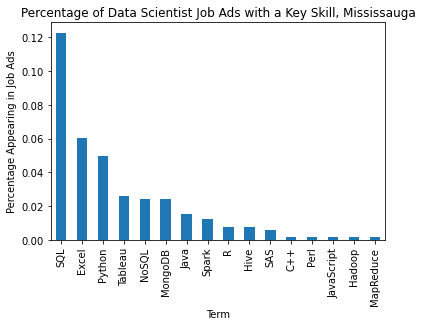

In [15]:
seattle_info = skills_info(city = 'Mississauga', state = 'ON', job_title = 'Data+Analyst') 

There were 103 jobs found, Mississauga
Getting page 1
Getting page 2
Getting page 3
Getting page 4
Getting page 5
Getting page 6
Getting page 7
Getting page 8
Getting page 9
Getting page 10
Done with collecting the job postings!
There were 87 jobs successfully found.


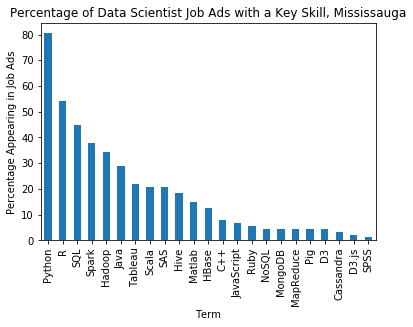

In [13]:
seattle_info = skills_info(city = 'Mississauga', state = 'ON', job_title = 'Data+Scientist') 

### Lab-2 Web Scraping Job Postings from Indeed

In [18]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time

In [24]:
URL = "https://ca.indeed.com/jobs?q=Data+Analyst&l=Toronto,+ON"
#conducting a request of the stated URL above:
page = requests.get(URL)
#specifying a desired format of “page” using the html parser - this allows python to read the various components of the page, rather than treating it as one long string.
soup = BeautifulSoup(page.text, "html.parser")
#printing soup in a more structured tree format that makes for easier reading
print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script id="polyfill-script-bundle">
   /* Disable minification (remove `.min` from URL path) for more info */

(function(self, undefined) {function ArrayCreate(r){if(1/r==-Infinity&&(r=0),r>Math.pow(2,32)-1)throw new RangeError("Invalid array length");var n=[];return n.length=r,n}function Call(t,l){var n=arguments.length>2?arguments[2]:[];if(!1===IsCallable(t))throw new TypeError(Object.prototype.toString.call(t)+"is not a function.");return t.apply(l,n)}function Get(n,t){return n[t]}function HasOwnProperty(r,t){return Object.prototype.hasOwnProperty.call(r,t)}function HasProperty(n,r){return r in n}function IsArray(r){return"[object Array]"===Object.prototype.toString.call(r)}function IsCallable(n){return"function"==typeof n}function RequireObjectCoercible(e){if(null===e||e===undefined)throw TypeError();return e}function SameValueNonNumber(e,n){return e===n}funct

In [49]:
# def extract_job_title_from_result(soup): 
#     jobs = []
#     for div in soup.find_all(name="h2", attrs={"class":"jobTitle jobTitle-color-purple"}):
#         for a in div.find_all(name="span"):
#             jobs.append(a["title"])
#     return(jobs)
# extract_job_title_from_result(soup)

In [51]:
def extract_job_title_from_result(soup): 
    jobs = []
    for div in soup.find_all(name="a", attrs={
            'class': re.compile(r'^tapItem fs-unmask result'), "target": "_blank"}):
        title = div.find(name="td", attrs={"class":"resultContent"})
        title_2 = title.find(name="span", attrs={"title":re.compile(r"^")})
        jobs.append(title_2["title"]) 
    return(jobs)
extract_job_title_from_result(soup)

['Fraud Analyst',
 'Data Analyst - Automation',
 'Data Analyst',
 'Business Analyst / Data Analyst SQL Tableau/PowerBI - $95k base - Toronto',
 'Data Analyst',
 'Data Analyst (Entry Level)',
 'Data/Business Intelligence Analyst (Remote)',
 'Statistical Data Analyst',
 'Data Analyst, Asset Managemnt',
 'Data Analyst',
 'Data Analyst',
 'PROGRAM ANALYST',
 'Junior Analyst - Data Quality Management',
 'Data Analyst',
 'Data Analyst']

In [52]:
def extract_company_from_result(soup): 
    companies = []
    for div in soup.find_all(name="a", attrs={
            'class': re.compile(r'^tapItem fs-unmask result'), "target": "_blank"}):
        company = div.find(name="div")
        company_2 = company.find(name="span", attrs={"class":"companyName"})
        companies.append(company_2.text.strip())
    return(companies)
 
extract_company_from_result(soup)

['BMO Financial Group',
 'CPUS Engineering Staffing Solutions',
 'Intact',
 'CorGTA Inc.',
 'Javelin Sports Inc',
 'Jarvis',
 'Mero',
 'ETS Educational Testing Service Canada',
 'Metrolinx',
 'The 2045 Collective',
 'WorkTango',
 'Ministry of Health',
 'EY',
 'Bolt Logistics',
 'Canaccede International Management Ltd.']

In [55]:
def extract_location_from_result(soup): 
    locations = []
    spans = soup.findAll('div', attrs={'class': 'companyLocation'})
    for span in spans:
        locations.append(span.text)
    return(locations)

extract_location_from_result(soup)

['Toronto, ON',
 'Etobicoke, ON',
 'Toronto, ON•Remote',
 'Toronto, ON•Temporarily Remote',
 'Toronto, ON•Remote',
 'Toronto, ON',
 'Toronto, ON•Remote',
 'Toronto, ON•Remote',
 'Toronto, ON',
 'Toronto, ON',
 'Toronto, ON',
 'Toronto, ON',
 'Toronto, ON',
 'Toronto, ON',
 'Toronto, ON•Remote']

In [57]:
def extract_salary_from_result(soup): 
    salaries = []
    for div in soup.find_all(name="a", attrs={
            'class': re.compile(r'^tapItem fs-unmask result'), "target": "_blank"}):
        try:
            div_two = div.find(name="td", attrs={"class":"resultContent"})
            div_three = div_two.find(name="div", attrs={"class":"metadata salary-snippet-container"})
            salaries.append(div_three.find(name="div", attrs={"class":"salary-snippet"}).text)
        except:
            salaries.append("Nothing_found")
    return(salaries)

extract_salary_from_result(soup)

['Nothing_found',
 '$46,765 - $130,066 a year',
 'Nothing_found',
 '$90,000 - $100,000 a year',
 '$16 - $18 an hour',
 'Nothing_found',
 '$30,000 - $65,000 a year',
 '$55,000 - $74,000 a year',
 '$64,598 - $90,100 a year',
 '$46,765 - $50,066 a year',
 'Nothing_found',
 '$65,174 - $91,119 a year',
 'Nothing_found',
 'Nothing_found',
 'Nothing_found']

In [60]:
def extract_summary_from_result(soup): 
    summaries = []
    divs = soup.findAll("div", attrs={"class": "job-snippet"})
    for div in divs:
        summaries.append(div.text.strip())
    return(summaries)
extract_summary_from_result(soup)

['Analyzes data and information to provide insights and recommendations.\nGathers and formats data into regular and ad-hoc reports, and dashboards.',
 'Support data query creation from various databases.\nGood understanding of data management and presentation skill.\nHours of Work: *35 hours/week.',
 '5+ years of relevant working experience as a data analyst (data applications and reporting).\nConsolidate data from various sources, ensuring data is clean.',
 'Strong experience working with both Qualitative and Quantitative based data for business decision making.\nPython experience or interest to do more in-depth data…',
 'Data mining and validating data integrity.\nExperience with forecasting and preparing data reports.\nDesigning and developing enterprise-wide data analysis and…',
 'Have completed at least one course (online or school) related to designing algorithms and data structures.\nOnce you successfully complete the Talent Incubation…',
 'Work with data to not only present it 

In [62]:
max_results_per_city = 100
city_set = ['Toronto','Vancouver','Montreal', 'Calgary', 'Edmonton', 'Ottawa']
columns = ["city", "job_title", "company_name", "location", "salary"]
sample_df = pd.DataFrame(columns = columns)

In [64]:
#scraping code:
for city in city_set:
    for start in range(0, max_results_per_city, 10):
        page = requests.get('http://ca.indeed.com/jobs?q=data+scientist+%2420%2C000&l=' + str(city) + '&start=' + str(start))
        time.sleep(10)  #ensuring at least 1 second between page grabs
        soup = BeautifulSoup(page.text, "lxml", from_encoding="utf-8")
        for div in soup.find_all(name="a", attrs={'class': re.compile(r'^tapItem fs-unmask result'), "target": "_blank"}):
            #specifying row num for index of job posting in dataframe
            num = (len(sample_df) + 1)
            
            #creating an empty list to hold the data for each posting
            job_post = [] 
            
            #append city name
            job_post.append(city) 
            
            #grabbing job title
            title = div.find(name="td", attrs={"class":"resultContent"})
            title_2 = title.find(name="span", attrs={"title":re.compile(r"^")})
            job_post.append(title_2["title"]) 
            
            #grabbing company name
            company = div.find(name="div")
            company_2 = company.find(name="span", attrs={"class":"companyName"})
            job_post.append(company_2.text.strip())
            
            #grabbing location name
            spans = div.findAll('div', attrs={'class': 'companyLocation'})
            for span in spans:
                job_post.append(span.text)
                
                
                
            #grabbing salary
            try:
                div_two = div.find(name="td", attrs={"class":"resultContent"})
                div_three = div_two.find(name="div", attrs={"class":"metadata salary-snippet-container"})
                job_post.append(div_three.find(name="div", attrs={"class":"salary-snippet"}).text)
            except:
                job_post.append("Nothing_found")
            
            print(job_post)
            
            sample_df = sample_df.append(pd.Series(job_post, index=columns), ignore_index=True)

        #saving sample_df as a local csv file — define your own local path to save contents 
        sample_df.to_csv("result-new.csv", encoding="utf-8")
 


['Toronto', 'Junior Machine Learning Engineer / Data Scientist', 'Virtus Groups', 'Toronto, ON', '$85,000 - $95,000 a year']
['Toronto', 'Data Analyst (Entry Level)', 'Jarvis', 'Toronto, ON', 'Nothing_found']
['Toronto', 'data scientist', 'Tiger Analytics Inc.', 'Toronto, ON•Remote', '$110,000 - $130,000 a year']
['Toronto', 'Data/Business Intelligence Analyst (Remote)', 'Mero', 'Toronto, ON•Remote', '$30,000 - $65,000 a year']
['Toronto', 'Data Scientist', 'Chubb INA Holdings Inc.', 'Toronto, ON', 'Nothing_found']
['Toronto', 'Data Scientist Intern (4 months)', 'IBM', 'Mississauga, ON', 'Nothing_found']
['Toronto', 'Data Scientist', 'Bolt Logistics', 'Toronto, ON', 'Nothing_found']
['Toronto', 'Data Scientist', 'Altair Engineering', 'Toronto, ON', '$59,394 - $141,315 a year']
['Toronto', 'Data Scientist', 'Equifax', 'Toronto, ON', 'Nothing_found']
['Toronto', 'Data Scientist', 'IBI Group', 'Toronto, ON', 'Nothing_found']
['Toronto', 'Data Scientist', 'Compass Digital Labs', 'Greater T